In [35]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
from scipy.optimize import least_squares
import src.correlations.correlations as corr

In [36]:
@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr

    

def phase_pred(fit_coords, pulse_idx, info):
    
    ref_coords = coords[0]

    relative_start_time = info[pulse_idx][0][0]
    pulse_duration_sec = info[pulse_idx][0][1] - info[pulse_idx][0][0]
    pulse_duration_chunks = int( pulse_duration_sec / (T_SPECTRA * v_acclen) )


    time_start = global_start_time + relative_start_time
    sat_ID = info[pulse_idx][1]

    pulse_channel_idx = info[pulse_idx][2]
    pulse_freq = outils.chan2freq(pulse_channel_idx, alias=True)

    # 'd' has one entry per second
    d = outils.get_sat_delay(ref_coords, fit_coords, tle_path, time_start, visibility_window+1, sat_ID)
    # 'delay' has one entry per chunk (~0.5s) 
    delay = np.interp(np.arange(0, v_nchunks) * v_acclen * T_SPECTRA, np.arange(0, int(visibility_window)+1), d)
    #thus 'pred' has one entry for each chunk
    pred = (-delay[:pulse_duration_chunks]+ delay[0]) *  2*np.pi * pulse_freq

    return pred



STANDARDIZED STARTING VARIABLES

In [37]:
T_SPECTRA = 4096/250e6

visibility_window = 1000

c_acclen = 10**6 
v_acclen = 30000

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

data_version = "MANUAL TESTER"

if data_version == "MANUAL TESTER":

    a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
    a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"

    global_start_time = 1721800002

    a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
    a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2

    bit_mode = 4

elif data_version == "SATDET TESTER":

    a1_coords = [79.41718333333333, -90.76735, 189]
    a2_coords = [79.41721666666666, -90.75885, 176] #ant2
    a3_coords = [79.41541666666667, -90.77308333333333, 175] #ant3

    a1_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_1_central"
    a2_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_2_east" #ant2
    a3_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_3_west" #ant3

    global_start_time = 1699625045

    bit_mode = 1

tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

dir_parents = []
dir_parents.append(a1_path)
dir_parents.append(a2_path)

coords = []
coords.append(a1_coords)
coords.append(a2_coords)

Need a filtered pulses list (so that there are 5 good ones we can trust)

In [38]:
#all these are detected. These numbers are the result of all the stuff above. What we care about starts now.

if data_version == "MANUAL TESTER":
        info = [[[715, 1110], 28654, 1836, 86568], 
                [[4950, 5270], 59051, 1836, 109993], 
                [[7000, 7145], 28654, 1836, 109993], 
                [[10975, 11440],59051, 1836, 86568],
                [[17005, 17530], 59051, 1837, 86568]]

elif data_version == "SATDET TESTER":
        info = [[[0, 215], 33591, 1849, 77396],
                [[505, 765], 28654, 1836, 67385],
                [[1815, 2250], 57166, 1836, 53673],
                [[4730, 4940], 25338, 1841, 71541]]

In [39]:
pulse_idx = 0

<h1 style="font-size:30pt">OBSERVED PHASES</h1>

In [40]:
relative_start_time = info[pulse_idx][0][0]
print(relative_start_time)
t_start = global_start_time + relative_start_time
t_end = t_start + visibility_window

files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

print('initial offset:', idx1-idx2)

idx_correction = info[pulse_idx][3] - 100000

if idx_correction>0:
    idx1_v = idx1 + idx_correction
    idx2_v = idx2
else:
    idx2_v = idx2 + np.abs(idx_correction)
    idx1_v = idx1
print("Corrected Starting Indices:", idx1_v, idx2_v)

channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
nchans=chanend-chanstart

pulse_chan = info[pulse_idx][2]
chanmap = channels[chanstart:chanend].astype(int)

ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')
ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')

0
initial offset: -1525879
Corrected Starting Indices: 427246 1975729
Not reading any data
ACCLEN RECEIVED IS 30000
took 0.160 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_1_central/16996/1699625038.raw
START SPECNUM IS 9461419 obj start at 9034173
ACCLEN RECEIVED IS 30000
took 0.159 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_2_east/16996/1699625013.raw
START SPECNUM IS 9739066 obj start at 7763337


In [43]:
m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((v_nchunks,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()

print(bit_mode)
print(f"--------- Processing Pulse Idx {pulse_idx} ---------")
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):

    if bit_mode == 4:
        xcorr = avg_xcorr_4bit_2ant_float(
            chunk1['pol0'], 
            chunk2['pol0'],
            chunk1['specnums'],
            chunk2['specnums'],
            m1+i*v_acclen,
            m2+i*v_acclen
            )

    elif bit_mode == 1:
        xcorr = corr.avg_xcorr_1bit(
            chunk1['pol0'], 
            chunk2['pol0'],
            chunk1['specnums'],
            nchans
        )
        
    visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
    print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)
vis_phase = np.angle(visibility_phased)

: 

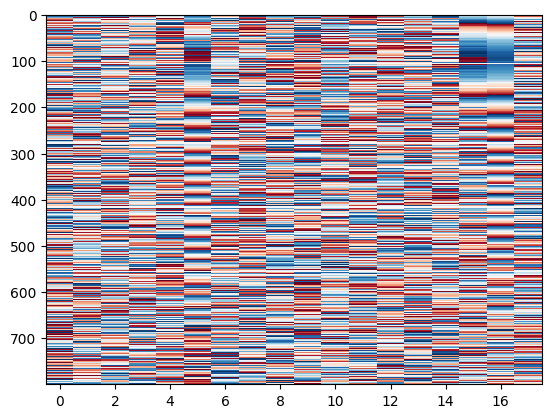

In [ ]:
plt.imshow(vis_phase[:800,:], aspect='auto',cmap='RdBu',interpolation="none")

15


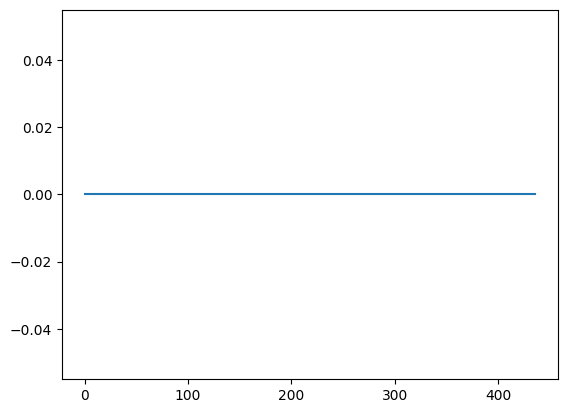

In [42]:
pulse_duration_sec = info[pulse_idx][0][1] - info[pulse_idx][0][0]
pulse_duration_chunks = int( pulse_duration_sec / (T_SPECTRA * v_acclen) )

goofy_index = np.where(chanmap == pulse_chan)[0][0]
print(goofy_index)

obs0 = np.unwrap(vis_phase[0:pulse_duration_chunks, 16])
plt.plot(obs0)

In [ ]:
pred0 = phase_pred(a2_coords, 0, info)
pred1 = phase_pred(a2_coords, 1, info)
pred2 = phase_pred(a2_coords, 2, info)

catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


803 803


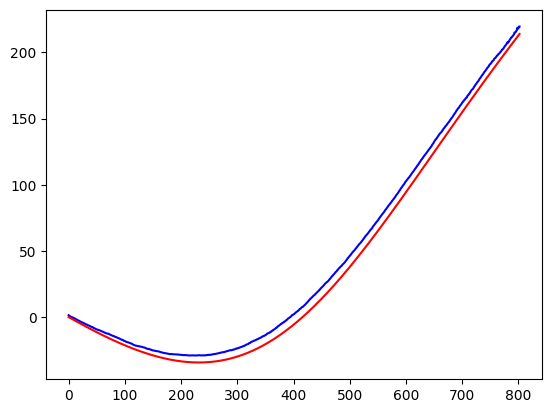

In [ ]:
plt.plot(obs0, color='blue')
plt.plot(pred0, color='red')
print(len(obs0), len(pred0))

<h1 style="font-size:30pt">FIT</h1>

In [133]:
# Inputs and outputs with different lengths
observed_data = [obs0]
print(len(obs0))

803


In [134]:
# Initial guess for coordinates (e.g., [scale, offset])
initial_guess = a2_coords

In [135]:
def residuals(coords, observed_data, phase_pred, info):
    """
    Compute the residuals between observed data and predicted data
    for all datasets simultaneously.
    """
    residuals_all = []

    # Loop over all observed datasets using enumerate to get the index 'i'
    for i, observed in enumerate(observed_data):
        # Extract start and end times for the current pulse index 'i'
        start_time = info[i][0][0]  # Start time (first element of info[i][0])
        end_time = info[i][0][1]    # End time (second element of info[i][0])
        
        # Compute predicted data for the current pulse_idx and coordinates
        predicted = phase_pred(coords, i, info)  # Pass 'i' instead of 'pulse_idx'
        
        # Compute the residuals (difference between observed and predicted)
        res = observed - predicted
        residuals_all.append(res.flatten())  # Flatten for least squares fitting
    
    # Combine all residuals into a single array (for least squares)
    return np.concatenate(residuals_all)


In [144]:
def fit_coordinates_all_datasets(observed_data, initial_coordinates, phase_pred, info):
    """
    Fit a single set of coordinates to all observed data using least squares.
    """
    
    # Perform least squares optimization using SciPy's least_squares
    result = least_squares(
        lambda coords: residuals(coords, observed_data, phase_pred, info),  # Pass a lambda that calls residuals
        initial_coordinates
    )
    
    # Optimized coordinates after fitting
    optimized_coordinates = result.x
    return optimized_coordinates, result


In [145]:
fit_coordinates_all_datasets(observed_data, initial_guess, phase_pred, info)

catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #2

(array([ 79.41698306, -90.75441555, 321.11731535]),
      message: Both `ftol` and `xtol` termination conditions are satisfied.
      success: True
       status: 4
          fun: [ 1.378e+00  1.351e+00 ...  1.151e+00  5.682e-01]
            x: [ 7.942e+01 -9.075e+01  3.211e+02]
         cost: 67.532812712524
          jac: [[ 0.000e+00 -0.000e+00  0.000e+00]
                [-3.907e+02  2.722e+01 -1.798e-03]
                ...
                [-4.201e+05 -2.345e+04  5.120e-03]
                [-4.204e+05 -2.351e+04  6.917e-03]]
         grad: [-7.253e-01 -4.099e-02 -9.220e-03]
   optimality: 0.7252662887331098
  active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
         nfev: 17
         njev: 9)

In [147]:
[79.41698306, -90.75441555, 321.11731535]



[79.41698306, -90.75441555, 321.11731535]

In [148]:
print(a2_coords)

[79.41721666666666, -90.75885, 176]
